In [2]:
import pandas as pd
import numpy as np
import re
import uuid
import seaborn as sns
import matplotlib.pyplot as plt
import plotly.express as px
from sklearn.cluster import KMeans

import plotly.graph_objects as go

from sklearn.decomposition import PCA

pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)
pd.set_option('display.max_colwidth', None)
pd.options.display.max_columns=None
pd.options.mode.chained_assignment = None

C:\Users\User\AppData\Local\Temp\ipykernel_24128\3040544828.py:1: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


In [3]:
stud_feb= pd.read_excel(r'C:\Users\User\studenti_cases\studenti_feb_24.xlsx')

In [4]:
# Добавление uuid
def text_to_uuid(text):
    return str(uuid.uuid5(uuid.NAMESPACE_DNS, text))
stud_feb.insert(0, 'uuid', stud_feb.apply(lambda row: text_to_uuid(' '.join(row['ФИО'])), axis=1))
stud_feb_fio_uuid_full=stud_feb.copy()
stud_feb_fio_uuid=stud_feb.drop_duplicates(subset='uuid')
# удаление лишних столбцов 
stud_feb.drop(columns=['ФИО','Номер ЛД','№п/п'], inplace=True)
# меняю названия столбцов
stud_feb=stud_feb.rename(columns={'Уровень подготовки':'degree','Специальность/направление':'faculty','Учебный год':'year','Полугодие':'semester','Дисциплина':'subject','Оценка (без пересдач)':'marks','Оценка (успеваемость)':'marks_final','Корпоративный Email':'email','Учебная группа':'group'})

In [5]:
# убираю все нули
# stud_feb = stud_feb.dropna(subset=['marks', 'marks_final'], how='all') 

In [6]:
# убираем будущее
stud_feb['marks'] = stud_feb['marks'].str.strip()
stud_feb['marks_final'] = stud_feb['marks_final'].str.strip()
stud_feb=stud_feb.query('year != "2024 - 2025" and year != "2025 - 2026" and year != "2026 - 2027" and year != "2027 - 2028" and year != "2028 - 2029" and year != "2029 - 2030" ').reset_index(drop=True)


In [7]:
# год и семестр вместе, убираем еще один слой будущего 
stud_feb['date']=stud_feb['year'] + stud_feb['semester']
stud_feb['date'] = stud_feb['date'].str.strip()
stud_feb=stud_feb.query('date != "2023 - 2024II полугодие"')


In [8]:
dict={"2020 - 2021I полугодие": "20_21_semestr1",
    "2020 - 2021II полугодие": "20_21_semestr2",
    "2021 - 2022I полугодие": "21_22_semestr1",
    "2021 - 2022II полугодие": "21_22_semestr2",
    "2022 - 2023I полугодие": "22_23_semestr1",
    "2022 - 2023II полугодие": "22_23_semestr2",
    "2023 - 2024I полугодие": "23_24_semestr1"}
stud_feb['date'].replace(dict,inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_24128\1356810080.py:8: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stud_feb['date'].replace(dict,inplace=True)


In [9]:
# датафрейм, в котором в котором пропущенны оба значения в оценках 
stud_null = stud_feb[(stud_feb['marks'].isnull()) & (stud_feb['marks_final'].isnull())]

In [10]:
# выделяем курс студента для каждого наблюдения 

In [11]:
stud_feb['year_group'] = stud_feb['group'].str.extract(r'-(\d{2})-')

stud_feb['year_group'] = stud_feb['year_group'].astype(float)

stud_feb['year_group'] = stud_feb['year_group'].apply(lambda x: 2000 + x)

In [12]:
stud_feb['year_group'].value_counts()

year_group
2020.0    85636
2022.0    67105
2021.0    65600
2023.0    22204
2019.0    20618
2018.0    13565
2017.0      799
2016.0      627
Name: count, dtype: int64

In [13]:
stud_feb.head(3)

,uuid,email,subject,marks,marks_final,semester,year,faculty,degree,group,date,year_group
0,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Автоматизация технологических процессов,Хорошо,Хорошо,II полугодие,2022 - 2023,Информатика и вычислительная техника,Академический бакалавр,БИВТ-20-4,22_23_semestr2,2020.0
1,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Алгоритмы дискретной математики,Хорошо,Хорошо,II полугодие,2021 - 2022,Информатика и вычислительная техника,Академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
2,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Базы данных,Хорошо,Хорошо,I полугодие,2021 - 2022,Информатика и вычислительная техника,Академический бакалавр,БИВТ-20-4,21_22_semestr1,2020.0


####  выбор нужного курса 

In [14]:
# к нижнему регистру столбец degree
stud_feb['degree'] = stud_feb['degree'].str.lower()

#выбираем только бакалавров
stud_feb = stud_feb[stud_feb['degree'].str.contains('бакалавр')]

In [15]:
# оставили только бакалвров, которые сейчас на 4 курсе 
stud_feb=stud_feb[stud_feb['year_group'] == 2020]

In [16]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 74416 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         74416 non-null  object 
 1   email        74416 non-null  object 
 2   subject      74406 non-null  object 
 3   marks        65134 non-null  object 
 4   marks_final  68350 non-null  object 
 5   semester     74406 non-null  object 
 6   year         74406 non-null  object 
 7   faculty      74416 non-null  object 
 8   degree       74416 non-null  object 
 9   group        74416 non-null  object 
 10  date         74406 non-null  object 
 11  year_group   74416 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.4+ MB


In [18]:
#### удаляем 20% случаев, где обе оценки пропущены 

In [19]:
# выделяем только тех, у кого обе оценки null 
vse_nuli=stud_feb[stud_feb['marks_final'].isnull() & stud_feb['marks'].isnull()]

In [20]:
grouped = vse_nuli.groupby('uuid')

# создаю датафрейм для сохранения строк после удаления 20% из каждой группы
nuli_out = pd.DataFrame(columns=vse_nuli.columns)

In [21]:
# оставляем 20% строк из каждой группы
for name, group in grouped:
    num_rows_to_keep = int(len(group) * 0.2)
    sampled_group = group.sample(n=num_rows_to_keep, random_state=42)  # Фиксируем random_state для воспроизводимости
    nuli_out = pd.concat([nuli_out, sampled_group])

C:\Users\User\AppData\Local\Temp\ipykernel_24128\324149620.py:5: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  nuli_out = pd.concat([nuli_out, sampled_group])


In [22]:
nuli_out.info()

<class 'pandas.core.frame.DataFrame'>
Index: 766 entries, 100399 to 224479
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         766 non-null    object 
 1   email        766 non-null    object 
 2   subject      766 non-null    object 
 3   marks        0 non-null      object 
 4   marks_final  0 non-null      object 
 5   semester     766 non-null    object 
 6   year         766 non-null    object 
 7   faculty      766 non-null    object 
 8   degree       766 non-null    object 
 9   group        766 non-null    object 
 10  date         766 non-null    object 
 11  year_group   766 non-null    float64
dtypes: float64(1), object(11)
memory usage: 77.8+ KB


In [23]:
# удалил 20% оценок с двумя нулями, предполагая что это пустые предметы по выбору 
indexes_to_drop = nuli_out.index
stud_feb.drop(index=indexes_to_drop, inplace=True)

In [24]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73650 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         73650 non-null  object 
 1   email        73650 non-null  object 
 2   subject      73640 non-null  object 
 3   marks        65134 non-null  object 
 4   marks_final  68350 non-null  object 
 5   semester     73640 non-null  object 
 6   year         73640 non-null  object 
 7   faculty      73650 non-null  object 
 8   degree       73650 non-null  object 
 9   group        73650 non-null  object 
 10  date         73640 non-null  object 
 11  year_group   73650 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.3+ MB


In [25]:
stud_feb.head(3)

,uuid,email,subject,marks,marks_final,semester,year,faculty,degree,group,date,year_group
0,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Автоматизация технологических процессов,Хорошо,Хорошо,II полугодие,2022 - 2023,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,22_23_semestr2,2020.0
1,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Алгоритмы дискретной математики,Хорошо,Хорошо,II полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
2,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Базы данных,Хорошо,Хорошо,I полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr1,2020.0


#### унификация оценок неудовлетворительно 

In [26]:
# заменяю пропущенные значения в столбце marks значением 'неудовлетворительно'
stud_feb['marks'].fillna('неудовлетворительно', inplace=True)
# заполняю соответствующие строки в столбце marks_final значением 'неудовлетворительно'
stud_feb['marks_final'].fillna('неудовлетворительно', inplace=True)

C:\Users\User\AppData\Local\Temp\ipykernel_24128\1957189399.py:2: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  stud_feb['marks'].fillna('неудовлетворительно', inplace=True)
C:\Users\User\AppData\Local\Temp\ipykernel_24128\1957189399.py:4: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a cop

In [27]:
stud_feb['marks_final'] = stud_feb['marks_final'].replace(['Неудовлетворительно', 'не зачтено', 'Не допущен'], 'неудовлетворительно')
stud_feb['marks'] = stud_feb['marks'].replace(['Неудовлетворительно', 'не зачтено', 'Не допущен'], 'неудовлетворительно')

In [28]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73650 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         73650 non-null  object 
 1   email        73650 non-null  object 
 2   subject      73640 non-null  object 
 3   marks        73650 non-null  object 
 4   marks_final  73650 non-null  object 
 5   semester     73640 non-null  object 
 6   year         73640 non-null  object 
 7   faculty      73650 non-null  object 
 8   degree       73650 non-null  object 
 9   group        73650 non-null  object 
 10  date         73640 non-null  object 
 11  year_group   73650 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.3+ MB


In [29]:
# студенты у которых пропущена дата предмет
data_subject_nuli=stud_feb[stud_feb['date'].isnull()]

In [30]:
stud_feb.dropna(inplace=True)

In [31]:
stud_feb.info()

<class 'pandas.core.frame.DataFrame'>
Index: 73640 entries, 0 to 349703
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   uuid         73640 non-null  object 
 1   email        73640 non-null  object 
 2   subject      73640 non-null  object 
 3   marks        73640 non-null  object 
 4   marks_final  73640 non-null  object 
 5   semester     73640 non-null  object 
 6   year         73640 non-null  object 
 7   faculty      73640 non-null  object 
 8   degree       73640 non-null  object 
 9   group        73640 non-null  object 
 10  date         73640 non-null  object 
 11  year_group   73640 non-null  float64
dtypes: float64(1), object(11)
memory usage: 7.3+ MB


#### разоварачиваю все оценки для каждого студента в один ряд 

In [32]:
# смотрю динамику пересдач 
stud_feb.head()

,uuid,email,subject,marks,marks_final,semester,year,faculty,degree,group,date,year_group
0,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Автоматизация технологических процессов,Хорошо,Хорошо,II полугодие,2022 - 2023,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,22_23_semestr2,2020.0
1,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Алгоритмы дискретной математики,Хорошо,Хорошо,II полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
2,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Базы данных,Хорошо,Хорошо,I полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr1,2020.0
3,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Безопасность жизнедеятельности,неудовлетворительно,зачтено,II полугодие,2021 - 2022,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,21_22_semestr2,2020.0
4,7ea6b823-4347-5f8a-8b70-36a92dc8542d,m2010218@edu.misis.ru,Инженерная компьютерная графика,Хорошо,Хорошо,I полугодие,2020 - 2021,Информатика и вычислительная техника,академический бакалавр,БИВТ-20-4,20_21_semestr1,2020.0


In [33]:
pivot_table = pd.pivot_table(stud_feb, index='uuid', columns='date', values='marks', aggfunc=lambda x: ', '.join(x)).reset_index()

In [34]:
# Преобразуем ячейки в списки
for column in pivot_table.columns[1:]:
    pivot_table[column] = pivot_table[column].apply(lambda x: x.split(', ') if isinstance(x, str) else [])

In [35]:
# Создаем DataFrame для каждой оценки и объединяем их
dfs = []
for column in pivot_table.columns[1:]:
    for idx, grades in enumerate(pivot_table[column]):
        expanded_df = pd.DataFrame({
            'uuid': [pivot_table.at[idx, 'uuid']] * len(grades),
            'date': [column] * len(grades),
            'grade': grades
        })
        dfs.append(expanded_df)

result_df = pd.concat(dfs, ignore_index=True)

In [36]:
result_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73640 entries, 0 to 73639
Data columns (total 3 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   uuid    73640 non-null  object
 1   date    73640 non-null  object
 2   grade   73640 non-null  object
dtypes: object(3)
memory usage: 1.7+ MB


In [37]:
# считаю количество двоек для каждого студента 
bad_marks_count = result_df[result_df['grade'] == 'неудовлетворительно'].groupby('uuid').size()

result_df['bad_marks'] = result_df['uuid'].map(bad_marks_count)

In [38]:
pivot_table_final= pd.pivot_table(stud_feb, index='uuid', columns='date', values='marks_final', aggfunc=lambda x: ', '.join(x)).reset_index()
# Преобразуем ячейки в списки
for column in pivot_table_final.columns[1:]:
    pivot_table_final[column] = pivot_table_final[column].apply(lambda x: x.split(', ') if isinstance(x, str) else [])
# Создаем DataFrame для каждой оценки и объединяем их
dfsf = []
for column in pivot_table_final.columns[1:]:
    for idx, grades in enumerate(pivot_table_final[column]):
        expanded_dff = pd.DataFrame({
            'uuid': [pivot_table_final.at[idx, 'uuid']] * len(grades),
            'date': [column] * len(grades),
            'grade': grades
        })
        dfsf.append(expanded_dff)

result_dff = pd.concat(dfsf, ignore_index=True)

# считаю количество двоек для каждого студента 
final_marks_count = result_dff[result_dff['grade'] == 'неудовлетворительно'].groupby('uuid').size()

result_dff['bad_marks_final'] = result_dff['uuid'].map(final_marks_count)

In [39]:
result_dff.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 73640 entries, 0 to 73639
Data columns (total 4 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   uuid             73640 non-null  object 
 1   date             73640 non-null  object 
 2   grade            73640 non-null  object 
 3   bad_marks_final  58469 non-null  float64
dtypes: float64(1), object(3)
memory usage: 2.2+ MB


In [40]:
result_df_full=result_df.fillna(0)
result_dff_full=result_dff.fillna(0)

result_df_full=result_df_full.drop_duplicates(subset='uuid')
result_dff_full=result_dff_full.drop_duplicates(subset='uuid')

In [41]:
result_df_full.head()

,uuid,date,grade,bad_marks
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,неудовлетворительно,18.0
8,00c4a339-6177-522d-8638-ce53266ae980,20_21_semestr1,Хорошо,4.0
14,0118adcd-86a0-5556-aea3-19a1df4af3a0,20_21_semestr1,Хорошо,36.0
20,01699bac-b70b-5746-a02e-79ed75425f93,20_21_semestr1,Неявка,19.0
26,01ee572a-44d0-53d9-a62e-c7ce700a7172,20_21_semestr1,неудовлетворительно,15.0


In [42]:
result_dff_full.head()

,uuid,date,grade,bad_marks_final
0,00bcd658-be72-55ce-a55d-922033d24e8d,20_21_semestr1,Удовлетворительно,7.0
8,00c4a339-6177-522d-8638-ce53266ae980,20_21_semestr1,Хорошо,0.0
14,0118adcd-86a0-5556-aea3-19a1df4af3a0,20_21_semestr1,Хорошо,32.0
20,01699bac-b70b-5746-a02e-79ed75425f93,20_21_semestr1,Удовлетворительно,1.0
26,01ee572a-44d0-53d9-a62e-c7ce700a7172,20_21_semestr1,Удовлетворительно,7.0


In [43]:
# объединяю bad и bad_final 

In [44]:
nice_cases=pd.merge(result_df_full[['uuid','bad_marks']],result_dff_full[['uuid','bad_marks_final']],how='inner',on='uuid')

In [45]:
nice_cases['nice_cases'] = nice_cases['bad_marks'] - nice_cases['bad_marks_final']

In [46]:
nice_cases['failds_corrected_percent']=round(nice_cases['nice_cases']/nice_cases['bad_marks']*100,2)
nice_cases.head()

,uuid,bad_marks,bad_marks_final,nice_cases,failds_corrected_percent
0,00bcd658-be72-55ce-a55d-922033d24e8d,18.0,7.0,11.0,61.11
1,00c4a339-6177-522d-8638-ce53266ae980,4.0,0.0,4.0,100.00
2,0118adcd-86a0-5556-aea3-19a1df4af3a0,36.0,32.0,4.0,11.11
3,01699bac-b70b-5746-a02e-79ed75425f93,19.0,1.0,18.0,94.74
4,01ee572a-44d0-53d9-a62e-c7ce700a7172,15.0,7.0,8.0,53.33


In [47]:
count_nice=nice_cases.query('nice_cases > 0')
count_nice.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 0 to 1313
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   uuid                      1096 non-null   object 
 1   bad_marks                 1096 non-null   float64
 2   bad_marks_final           1096 non-null   float64
 3   nice_cases                1096 non-null   float64
 4   failds_corrected_percent  1096 non-null   float64
dtypes: float64(4), object(1)
memory usage: 51.4+ KB


In [48]:
# посмотреть группу тех,кто испрвляет больше n % двоек 
nice_cases.describe()

,bad_marks,bad_marks_final,nice_cases,failds_corrected_percent
count,1381.000000,1381.000000,1381.000000,1253.000000
mean,10.978277,5.151340,5.826937,55.667446
std,10.649194,7.138758,7.356238,34.294647
min,0.000000,0.000000,-10.000000,-50.000000
25%,3.000000,1.000000,1.000000,30.000000
50%,8.000000,2.000000,3.000000,58.140000
75%,16.000000,7.000000,8.000000,85.710000
max,65.000000,50.000000,45.000000,100.000000


### общая статистика по студентам бакалврам, обучающимся сейчас на 4 курсе 

In [49]:
# всего студентов в анализе 
print('всего студентов', len(stud_feb['uuid'].unique()))
# все двоечники
print('все двоечники',nice_cases.query('bad_marks != 0').shape[0])
# не двоечники
print('не двоечники',nice_cases.query('bad_marks == 0').shape[0])
# общее количество двоек
print('общее количество двоек',nice_cases['bad_marks'].sum())
# общее количество неисправленных  двоек
print('общее количество неисправленных  двоек',nice_cases['bad_marks_final'].sum())
# процент неисправленных двоек от всех двоек 
print('процент неисправленных двоек от всех двоек ',round(nice_cases['bad_marks_final'].sum()/nice_cases['bad_marks'].sum()*100,2))

# процент исправленных двоек от всех двоек 
print('процент исправленных двоек от всех двоек ',round(nice_cases['nice_cases'].sum()/nice_cases['bad_marks'].sum()*100,2))
# количество двоечников, которые имеют хоть одну неисправленную двойку
print('количество двоечников, которые имеют хоть одну неисправленную двойку',len(nice_cases[nice_cases['bad_marks_final']>0]))

# общее количество неисправленных двоек 
print('общее количество неисправленных двоек ',nice_cases['bad_marks_final'].sum())
# количество двоечников, которые имеют хоть одну исправленную двойку
print('количество двоечников, которые имеют хоть одну исправленную двойку',len(nice_cases[nice_cases['nice_cases']>0]))

# общее количество исправленных двоек 
print('общее количество исправленных двоек ',nice_cases['nice_cases'].sum())

всего студентов 1381
все двоечники 1253
не двоечники 128
общее количество двоек 15161.0
общее количество неисправленных  двоек 7114.0
процент неисправленных двоек от всех двоек  46.92
процент исправленных двоек от всех двоек  53.08
количество двоечников, которые имеют хоть одну неисправленную двойку 1039
общее количество неисправленных двоек  7114.0
количество двоечников, которые имеют хоть одну исправленную двойку 1096
общее количество исправленных двоек  8047.0


In [50]:
nice_cases_fig= nice_cases[nice_cases['nice_cases'] > 0]

In [51]:
nice_cases_fig.head()

,uuid,bad_marks,bad_marks_final,nice_cases,failds_corrected_percent
0,00bcd658-be72-55ce-a55d-922033d24e8d,18.0,7.0,11.0,61.11
1,00c4a339-6177-522d-8638-ce53266ae980,4.0,0.0,4.0,100.00
2,0118adcd-86a0-5556-aea3-19a1df4af3a0,36.0,32.0,4.0,11.11
3,01699bac-b70b-5746-a02e-79ed75425f93,19.0,1.0,18.0,94.74
4,01ee572a-44d0-53d9-a62e-c7ce700a7172,15.0,7.0,8.0,53.33


In [52]:
nice_cases_fig.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1096 entries, 0 to 1313
Data columns (total 5 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   uuid                      1096 non-null   object 
 1   bad_marks                 1096 non-null   float64
 2   bad_marks_final           1096 non-null   float64
 3   nice_cases                1096 non-null   float64
 4   failds_corrected_percent  1096 non-null   float64
dtypes: float64(4), object(1)
memory usage: 51.4+ KB


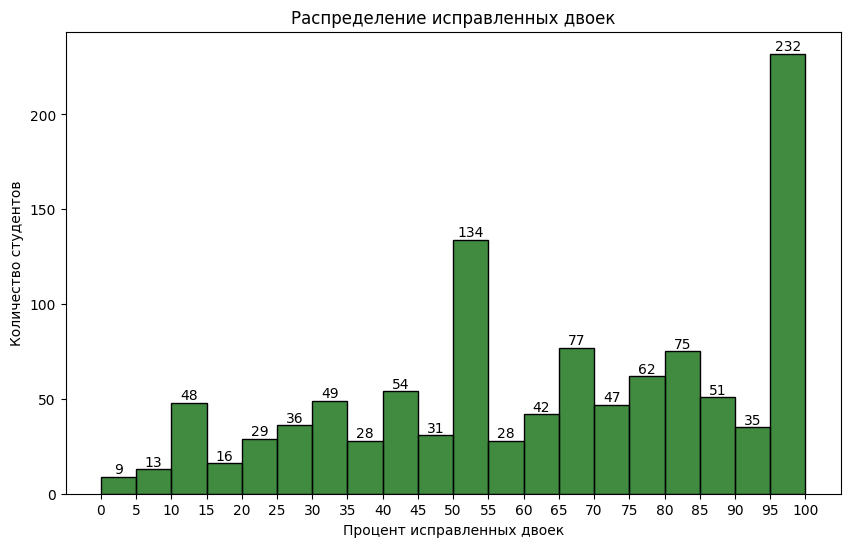

In [53]:
# по оси Y количество студентов, по оси X процент исправленных двоек за все время обучения 
# над каждым столбцом указано количество студентов 

# шаги на оси ox
x_ticks = np.arange(0, 101, 5)

# распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram=sns.histplot(nice_cases_fig['failds_corrected_percent'], bins=range(0, 101, 5), kde=False, color='darkgreen')
plt.xticks(x_ticks)
plt.title('Распределение исправленных двоек')
plt.xlabel('Процент исправленных двоек')
plt.ylabel('Количество студентов')

# количество наблюдений в каждой группе
for p in histogram.patches:
    histogram.annotate(f'{p.get_height()}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24128\2792665304.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_bad_marks = nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].median()


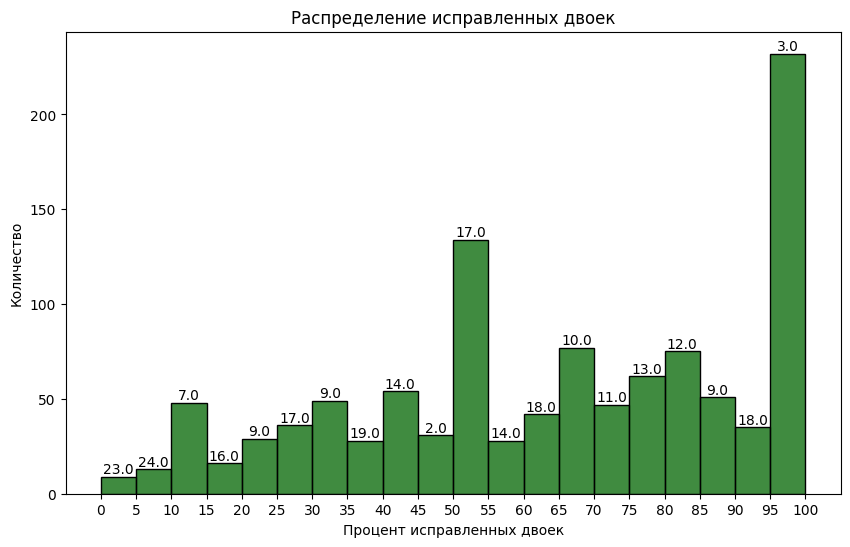

In [54]:
# в этом анализе бакалавры, которые сейчас обучаются на 4 курсе
# по оси Y количество студентов, по оси X процент исправленных двоек за все время обучения 
# над каждым столбцом указано значение медианы двоек(без учета пересдач) у студентов, находящихся в этом столбце 

# Группировка данных по столбцу 'failds_corrected_percent' и расчет медианы 'bad_marks' в каждой группе
median_bad_marks = nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].median()

# Шаги на оси ox
x_ticks = np.arange(0, 101, 5)

# Распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram = sns.histplot(nice_cases_fig['failds_corrected_percent'], bins=range(0, 101, 5), kde=False, color='darkgreen')
plt.xticks(x_ticks)
plt.title('Распределение исправленных двоек')
plt.xlabel('Процент исправленных двоек')
plt.ylabel('Количество')

# Количество наблюдений в каждой группе
for i, p in enumerate(histogram.patches):
    median_value = median_bad_marks.iloc[i]
    histogram.annotate(f'{median_value}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()

C:\Users\User\AppData\Local\Temp\ipykernel_24128\737071794.py:6: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  median_bad_marks = round(nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].mean(),2)


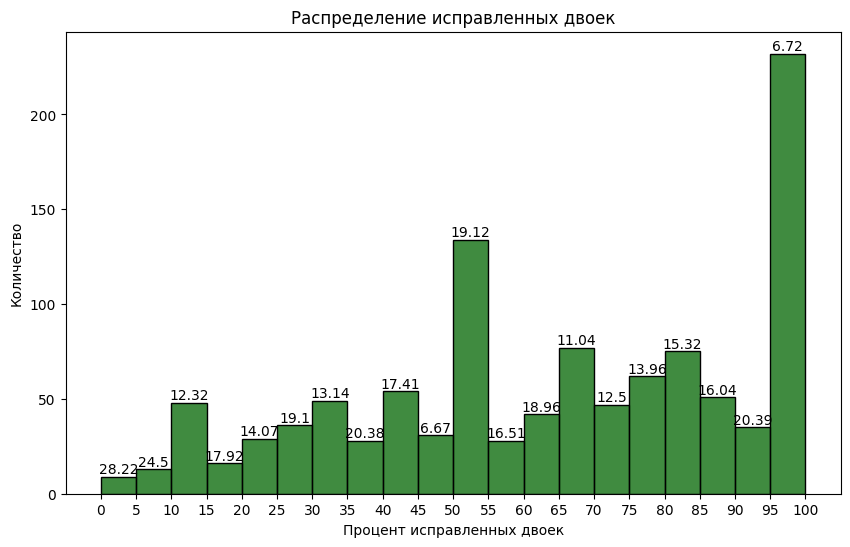

In [55]:
# в этом анализе бакалавры, которые сейчас обучаются на 4 курсе
# по оси Y количество студентов, по оси X процент исправленных двоек за все время обучения 
# над каждым столбцом указано среднее значение двоек(без учета пересдач) у студентов, находящихся в этом столбце 

# Группировка данных по столбцу 'failds_corrected_percent' и расчет медианы 'bad_marks' в каждой группе
median_bad_marks = round(nice_cases_fig.groupby(pd.cut(nice_cases_fig['failds_corrected_percent'], bins=np.arange(0, 105, 5)))['bad_marks'].mean(),2)

# Шаги на оси ox
x_ticks = np.arange(0, 101, 5)

# Распределение процента исправленных двоек 
plt.figure(figsize=(10, 6))
histogram = sns.histplot(nice_cases_fig['failds_corrected_percent'], bins=range(0, 101, 5), kde=False, color='darkgreen')
plt.xticks(x_ticks)
plt.title('Распределение исправленных двоек')
plt.xlabel('Процент исправленных двоек')
plt.ylabel('Количество')

# Количество наблюдений в каждой группе
for i, p in enumerate(histogram.patches):
    median_value = median_bad_marks.iloc[i]
    histogram.annotate(f'{median_value}', (p.get_x() + p.get_width() / 2., p.get_height()), ha='center', va='center', xytext=(0, 5), textcoords='offset points')

plt.show()